In [1]:
%matplotlib inline

In [3]:
from fastai import *

## MNIST SGD

In [4]:
!mkdir data/mnist

In [6]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -O data/mnist/mnist.pkl.gz

--2018-12-29 01:46:12--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘data/mnist/mnist.pkl.gz’

data/mnist/mnist.pk 100%[===================>]  15.42M  8.43MB/s    in 1.8s    

2018-12-29 01:46:15 (8.43 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [16168813/16168813]



In [7]:
path = Path('data/mnist')

In [8]:
path.ls()

[PosixPath('data/mnist/mnist.pkl.gz')]

In [9]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [10]:
x_train[0].shape

(784,)

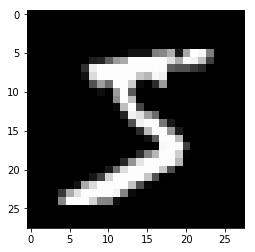

In [12]:
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')

In [13]:
x_train.shape

(50000, 784)

In [14]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [15]:
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [16]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [17]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [18]:
class MnistLogistic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
    
    def forward(self, x):
        return self.lin(x)

In [19]:
model = MnistLogistic().cuda()

In [20]:
model

MnistLogistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [21]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [22]:
model(x).shape

torch.Size([64, 10])

In [23]:
lr = 2e-2

In [24]:
loss_func = nn.CrossEntropyLoss()

In [25]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    w2 = 0
    for p in model.parameters():
        w2 += (p** 2).sum()
    
    loss = loss_func(y_hat, y) + w2 * wd # Calculate loss
    
    loss.backward() # Calculate gradient in backward pass
    
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad) # SGD
            p.grad.zero_() # Zero out the gradient
    
    return loss.item() # Return calculated loss

In [26]:
losses = [update(x, y, lr) for x, y in data.train_dl]

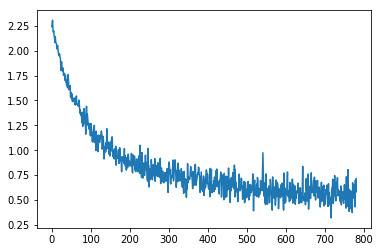

In [28]:
plt.plot(losses);

In [30]:
# A Feedforward Network

class MnistNN(nn.Module):
    
    def __init__(self, n_neurons=50):
        super().__init__()
        self.lin1 = nn.Linear(784, n_neurons)
        self.lin2 = nn.Linear(n_neurons, 10)
    
    def forward(self, x):
        
        x = self.lin1(x)
        x = F.relu(x)
        
        return self.lin2(x)

In [32]:
model = MnistNN().cuda()

In [33]:
losses = [update(x, y, lr) for x, y in data.train_dl]

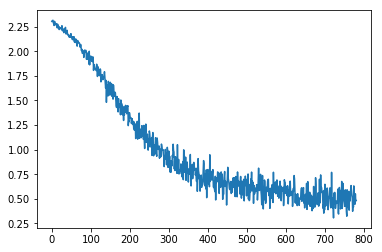

In [34]:
plt.plot(losses);

In [35]:
model = MnistNN().cuda()

In [36]:
def update_adam(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward() # backward pass
    opt.step() # update weights
    opt.zero_grad() # zero out the gradient
    
    return loss.item()

In [37]:
losses = [update_adam(x, y, 1e-3) for x, y in data.train_dl]

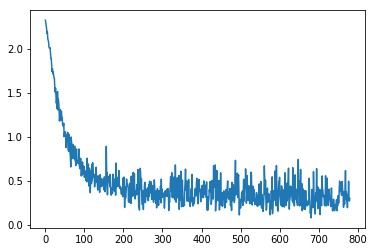

In [38]:
plt.plot(losses)

In [39]:
learn = Learner(data, MnistNN(), loss_func=loss_func,
               metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


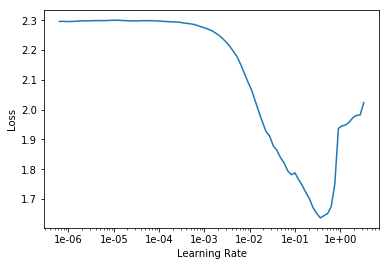

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.155593,0.132208,0.961700


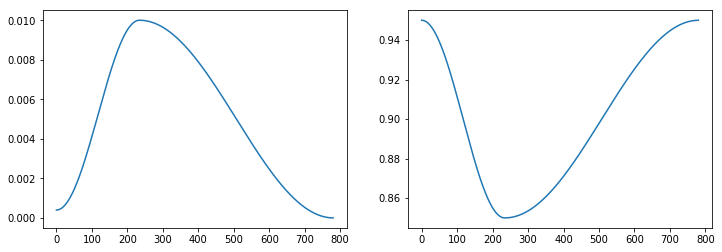

In [42]:
learn.recorder.plot_lr(show_moms=True)

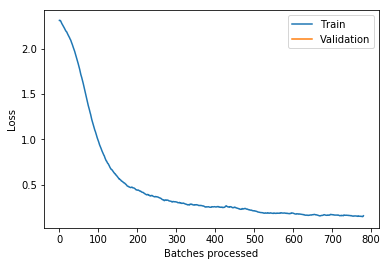

In [43]:
learn.recorder.plot_losses()